## Exercise 1: Load images and create random distortions

We provide the function `load_random_simpsons_face(N, D, duplicates=False)` which loads and returns `N` random faces of size `DxD` (optionally with duplicates), i.e. a `numpy` array of shape `(N, D, D, 3)`. The images are in the provided zip file and should be extractet automatically. Write a function `convert_images2bin_pattern(images)` which converts the images to black and white such that only $± 1$ pixel values are allowed and only one channel is retained. That is the RGB-image should be converted to a binary one. At the end the image should be reshaped to a vector such that the output of the convert function is of shape `(N,D**2)`.

Further, write a second function `corrupt_binary_patterns(patterns, p_flip)` that takes `patterns` of the form as returned by the first function and returns a corrupted copy of them. A pattern is corrupted by flipping each pixel with a probability of `p_flip`.

Test your functions and visualize the results. i.e. show the original image, the black-white image and the corrupted image. For binary patterns use the cmap `binary` for the function `show_images()`.

<Figure size 432x288 with 0 Axes>

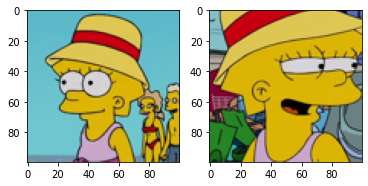

<Figure size 432x288 with 0 Axes>

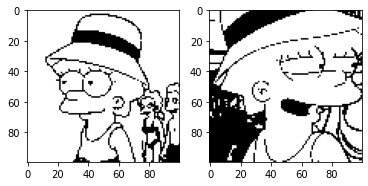

<Figure size 432x288 with 0 Axes>

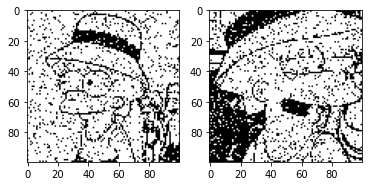

In [1]:
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from glob import glob
from tqdm.notebook import tqdm
import zipfile
from PIL import Image

np.random.seed(0)

def _load_images(image_paths, n_pixel):
    """helper function to load images from given paths

    Args:
        image_paths ([str]): list of strings indicating paths to images
        n_pixel (int): number of pixels per side for each image

    Returns:
        [PIL.Image.Image]: list of PIL.Image
    """
    images = []
    for path in image_paths:
        im = Image.open(path)
        im = im.resize((n_pixel,n_pixel))
        images.append(im)
    return images

def load_random_simpsons_face(N, D, duplicates=False):
    """extract zip file and loads a random number of images into numpy 
    array
    
    Args: 
        N (int): number of images to draw randomly
        D (int): number of pixels per side for each image
        duplicates (bool): defaults to False, if one image can be drawn multiple times
    
    Returns:
        np.ndarray: numpy array of images with shape N x D x D x 3
    
    """
    zippath = 'simpsons_faces.zip'
    zip_dest = zippath[:-4]
    if not os.path.exists(zip_dest):
        with zipfile.ZipFile(zippath, 'r') as zip_ref:
            zip_ref.extractall('.')
    
    img_paths = glob(zip_dest+'/**/*.png', recursive=True)
    selected_imgs = np.random.choice(img_paths, size=N, replace=duplicates)
    imgs = [np.array(x) for x in _load_images(selected_imgs,D)]
    
    return np.array(imgs)
       
def show_images(imgs, cmap=None):
    """plot images given as a numpy array in a row. Also reshapes
    patterns into images to plot them.
    
    
    Args:
        imgs (np.ndarray): batch of images as np.array of shape N x D x D x C
                           can also be a batch of patterns of shape N x D**2 
        cmap (None|str): optionally a string identifying a matplotlib.colormap
                         for binary patterns/images use 'binary'
                         for continuous patterns/images use 'gray'
        
    Returns:
        None
    """
    # imgs is of shape (batch, width, width, channel)
    # show images in a row
    if not cmap: # defaults to binary cmap if imags is batch of pattern 
        if imgs.ndim == 2:
            cmap = 'binary'
            
    if imgs.ndim == 2:
        # reshape pattern into img tensor with channel dim
        N, D2 = imgs.shape
        imgs = imgs.reshape(N, int(np.sqrt(D2)), -1,1)
    N, W, _, C = imgs.shape
    plt.figure()
    fig, axes = plt.subplots(1, N)
    axes = [axes] if N == 1 else axes
    for im, ax in zip(imgs, axes):
        ax.imshow(im, cmap=cmap)
    plt.show()
      
def convert_images2bin_pattern(images):
    """converts images to binary black and white with pixel values
    in set {-1,+1}

    Args:
        images (np.ndarray): batch of images as np.array of shape N x D x D x C

    Returns:
        np.ndarray: numpy array with shape N x D*D
    """
    N, D,_,C = images.shape
    assert C == 3, 'invalid image shape'
    ########## YOUR SOLUTION HERE ##########
    
    imgs_pil = [Image.fromarray(image, "RGB") for image in images]
    imgs_gray = np.array([np.asarray(img.convert("L")) for img in imgs_pil])
    imgs_gray = np.array([np.interp(img, (img.min(), img.max()), (-1, +1)) for img in imgs_gray])
    imgs_bin = np.where(imgs_gray >= 0, -1,1)
    return np.reshape(imgs_bin,(imgs_bin.shape[0],-1))

rng = np.random.default_rng()
def corrupt_binary_patterns(patterns, p_flip=0.1):
    """corrupts binary pattern by flipping each pixel with probability p_flip.
    A pixel is an element in {-1, +1}.
    
    Args:
        patterns (np.ndarray): batch of patterns as np.array of shape N x D**2
        
    Returns:
        np.ndarray: corrupted numpy array with same shape as patterns
    """
    assert patterns.ndim == 2, 'inavlid pattern shape'
    ########## YOUR SOLUTION HERE ##########
    flip_matrix = rng.choice([1,-1], size=patterns.shape, p=[1-p_flip, p_flip])
    return patterns*flip_matrix
    
    
images = load_random_simpsons_face(2,100)
show_images(images)
bins = convert_images2bin_pattern(images)
show_images(bins, "binary")
corr = corrupt_binary_patterns(bins, p_flip=0.1)
show_images(corr, "binary")

## Exercise 2: Batchify the Hopfield Network

Consider a Hopfield network with $D$ neurons. You are given a matrix $\mathbf{X} \in \{-1,+1\}^{N \times D}$ representing a batch of $N$ patterns. Write down the Hebbian weight matrix $\mathbf{W}$ that stores these patterns in a Hopfield network (cf. Eq. (5.16) in the script), the batched (synchronous) state update $\mathbf{X}^{\text{new}}$ for inital states $\mathbf{X}^{\text{old}}$ (cf. Eq. (5.12) in the script), and the average energy $E$ of the batch $\mathbf{X}$ (cf. Eq. (5.13) in the script). 

*Use only matrix operations for this! That is, do not decompose the matrices $\mathbf{X}, \mathbf{Q}, \mathbf{W}$ into vectors or single elements. This will enable us to implement the batched Hopfield network efficiently using standard linear algebra routines instead of looping over samples.*

*Do not use bias (threshold) units, i.e., assume them to be zero.*

*TLDR: Rewrite equations (5.12), (5.13), and (5.16) in matrix form neglecting bias terms.*

#### Hebbian weight matrix W:

\begin{align}
W &= \dfrac{1}{N}(\sum_{n=1}^N x^{(n)} {x^{(n)}}^T) - I_D &(5.16)
\end{align}

The weights are computed as a sum of outer products, which can be written in Matrix form:
\begin{align}
W &= \dfrac{1}{N}(X^TX) - I_D
\end{align}

#### State Update for X:

\begin{align}
x^{\text{new}} &= \text{sign}(W x^{\text{old}} - b) & (5.12)
\end{align}

We can rewrite inner product to compute $X^{\text{new}}$ and leave out bias:

\begin{align}
X^{\text{new}} &= \text{sign}(W {X^{\text{old}}}^T)^T & (5.12)
\end{align}


#### Average Energy E of Batch X:

\begin{align}
E &= -\frac{1}{2} x^T W x - x^T b & (5.13)
\end{align}

##### To get average energy we need to take the mean over N samples: (bias can be neglected)

1.) Calculate energy with matrix X instead of vector x. We only take diagonal entries, because we only want the same x vector multiplied from left and right.
\begin{align}
E_{\text{diag}} &= -\frac{1}{2} \text{diag}(X W X^T) 
\end{align}
2.)Average the N diagonal entries
\begin{align}
E_{\text{avg}} &= \frac{1}{N} 1_N^T E_{\text{diag}} 1_N
\end{align}
, with $1_N$ being a matrix of size $Nx1$ with only ones as entries. This matrix can be used to sum all the elements of the diagonal matrix $E_{\text{diag}}$.

## Exercise 3: Implement the Hopfield Network
Write the three functions `store(self,X)` and `retrieve(self,W, X)` and `energy(self,X)` for the class `ClassicalHopfield`. The first function should take a batch of patterns `X` and return the Hebbian weight matrix `W` that stores these patterns. The second function should a batch of states (e.g. corrupted patterns) `X` and should retrieve stored patterns by iterating the synchronous batched Hopfield dynamics established in the previous exercise. Stop the iteration when all states have converged. Compute and print the total energy of the network on every iteration. 

In [2]:
class ClassicalHopfield:
    """class providing the classical hopfield model which can learn patterns and retrieve them
    Attributes
    ----------
    size : int
        dimension D of single pattern vector 
    W : np.ndarray, DxD
        weight matrix of the hopfield network
    b : np.ndarray, D
        bias vector, in our case just set to 0
    
    Methods
    -------
    store(patterns) : None
        learn given array of patterns in {-1,1}^D, shape NxD with N=#of patterns, D=size of patterns
    retrieve(test_pat, reps=1) : np.ndarray
        retrieves a memorized pattern from the provided one
    """

    def __init__(self, pat_size):
        """Constructor of classical Hopfield network
        Args:
            pat_size (int): the dimension D of a single pattern vector
        """
        self.size = pat_size
        self.W = np.zeros((self.size,self.size))
        self.b = np.zeros(self.size)
        
    def store(self, X):
        """learns the weight matrix by applying hebbian learning rule 
        to the provided patterns, without self reference
        Args:
            X (np.ndarray):  NxD numpy arrays where patterns are row-wise
        """
        N, D = X.shape
        
        err_msg = f"Can't store patterns of size {D}. Need to initialize ClassicalHopfield with correct size"
        assert D == self.size, err_msg
        
        ########## YOUR SOLUTION HERE ##########
        self.W = (1/N * (X.T @ X)) - np.identity(D)
    
    def retrieve(self, X, reps=10, verbose=False):
        """[summary]
        Args:
            X (np.ndarray): the corrupted test patterns which should be retrieved
            reps (int, optional): number of times the retrieval update should be applied . Defaults to 1.
        Returns:
            np.ndarray: the retrieved pattern of shape Dx1
        """
        N, D = X.shape
        ########## YOUR SOLUTION HERE ##########
        
        cur_e = self.energy(X)
        if verbose:
            print(0, cur_e)
        
        energies = [cur_e]
        for i in range(1,reps+1):
            
            X = np.sign(self.W @ X.T).T
            
            cur_e = self.energy(X)
            if verbose:
                print(i, cur_e)
            if all(cur_e == energies[-3:]):
                break
            energies.append(cur_e)
        return X
        
    
    def energy(self, X):
        """calculates energy for pattern batch according to hopfield model
        Args:
            X (np.ndarray): the patterns for which the energy should be calculated
        Returns:
            float: the calculated energy
        """
        assert type(X) is np.ndarray
        N, D = X.shape
        ########## YOUR SOLUTION HERE ##########
        
        I = np.ones((N,1))
        E = 1/N * (I.T @ np.diag(np.diag((-1/2*(X @ self.W @ X.T)))) @ I)
        return E
    

## Exercise 4: Test the Hopfield Network

To test your Hopfield network and initialize it for patterns of size 16*16, create a batch of 6 random faces with 256 neurons using `load_random_simpsons_face` and `convert_images2bin_pattern` and store them using `store(self,X)`. Then corrupt these patterns with a probability of a) 0.1 and b) 0.4 using `corrupt_binary_patterns` and try to restore the original patterns using `retrieve(self,X)`. 
Finally, answer the three following questions experimentally

*Question 1: What do you observe? Plot each step of your experiment. That is show the original images, the patterns, the corrupted and retrieved ones.*

*Question 2: Fixing the number of patterns to 5 and average over 100 trials, what is the maximum probability of flips the Hopfield network can handle? Give experimental evidence via some plots.*

*Question 3: Fixing the probability of flips to 0.4 and average over 100 trials, what is the maximum number of patterns the Hopfield network can restore? Give experimental evidence via some plots.*


################# original images #################


<Figure size 432x288 with 0 Axes>

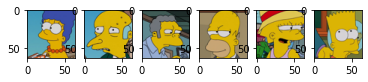

################# binary images ###################


<Figure size 432x288 with 0 Axes>

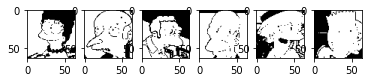

########## corrupted images: p=0.1 ###############


<Figure size 432x288 with 0 Axes>

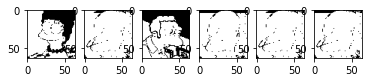

########## corrupted images: p=0.4 ###############


<Figure size 432x288 with 0 Axes>

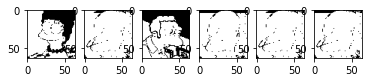

In [3]:
########## YOUR SOLUTION HERE ##########

# Question 1
print("################# original images #################")
images = load_random_simpsons_face(6,64)
show_images(images)

print("################# binary images ###################")
bins = convert_images2bin_pattern(images)
show_images(bins)

model = ClassicalHopfield(bins.shape[1])
model.store(bins)

p = 0.1
print(f"########## corrupted images: p={p} ###############")
corr = corrupt_binary_patterns(bins, p_flip=p)
retrieved = model.retrieve(corr)
show_images(retrieved)

p = 0.4
print(f"########## corrupted images: p={p} ###############")
corr = corrupt_binary_patterns(bins, p_flip=p)
retrieved = model.retrieve(corr)
show_images(retrieved)

N:5 | p:0.0 | average pixel difference:66.0 | relative avg. p. diff:0.05 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

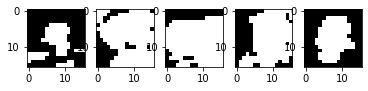

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

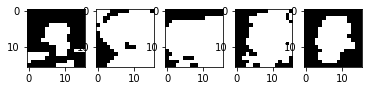



N:5 | p:0.1 | average pixel difference:66.0 | relative avg. p. diff:0.05 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

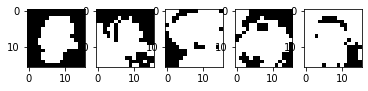

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

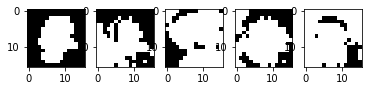



N:5 | p:0.2 | average pixel difference:71.0 | relative avg. p. diff:0.06 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

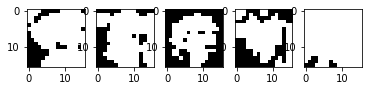

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

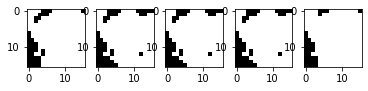



N:5 | p:0.3 | average pixel difference:87.0 | relative avg. p. diff:0.07 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

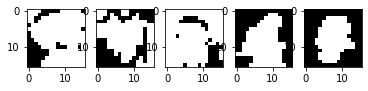

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

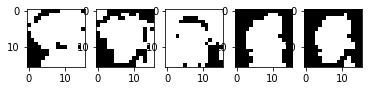



N:5 | p:0.4 | average pixel difference:144.0 | relative avg. p. diff:0.11 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

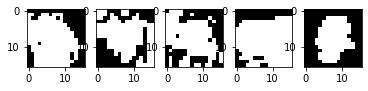

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

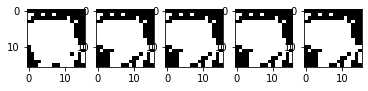



N:5 | p:0.5 | average pixel difference:632.0 | relative avg. p. diff:0.49 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

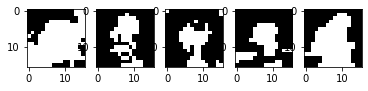

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

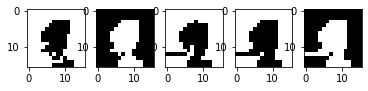



N:5 | p:0.6 | average pixel difference:1123.0 | relative avg. p. diff:0.88 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

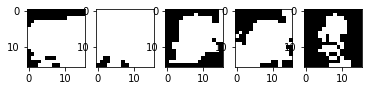

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

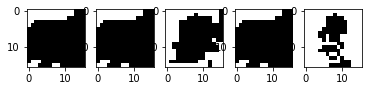



N:5 | p:0.7 | average pixel difference:1181.0 | relative avg. p. diff:0.92 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

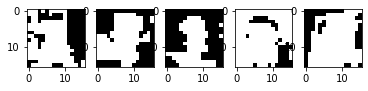

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

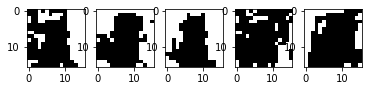



N:5 | p:0.8 | average pixel difference:1199.0 | relative avg. p. diff:0.94 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

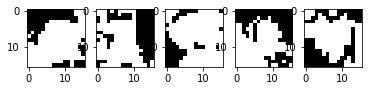

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

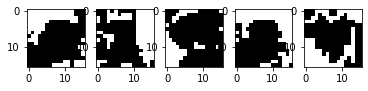



N:5 | p:0.9 | average pixel difference:1200.0 | relative avg. p. diff:0.94 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

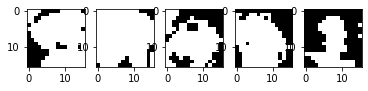

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

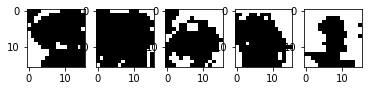



N:5 | p:1.0 | average pixel difference:1214.0 | relative avg. p. diff:0.95 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

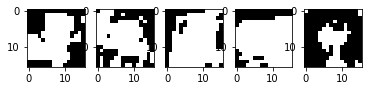

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

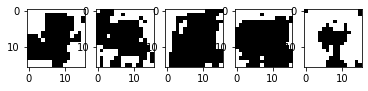

In [4]:
# Question 2
n_trials = 100
image_size = 16
N = 5

step_size = 10
p_list = np.array(range(0,100+step_size,step_size))/100
for p in p_list:
    pixel_diff = []
    for n in range(n_trials):
        images = load_random_simpsons_face(N,image_size)

        # binary images
        bins = convert_images2bin_pattern(images)
        # store in model
        model = ClassicalHopfield(bins.shape[1])
        model.store(bins)
        # corrupted images
        corr = corrupt_binary_patterns(bins, p_flip=p)
        # retrieve pattern
        retrieved = model.retrieve(corr)
        # calc pixel diff
        p_diff = np.sum(1/2*np.abs(bins - retrieved))
        pixel_diff.append(p_diff)
    
    print(f"N:{N} | p:{p} | average pixel difference:{np.around(np.mean(pixel_diff))} | relative avg. p. diff:{np.around(np.mean(pixel_diff)/(N*image_size**2), 2)} | number of pixels:{N*image_size**2}")
    print(f"Original Binary Patterns")
    show_images(bins)
    print(f"Retrieved Binary Patterns")
    show_images(retrieved)
    print("\n")
    
    

Until p=0.4 it works relatively well then the retrieval starts to break -> Number of wrong pixels starts to increase heavily! Interestingly it starts to work from 0.7 upwards again, but it predicts the negative. Since so many pixels were flipped the shape of the image starts to get better again, however the values all the values are flipped.

N:1 | p:0.4 | average pixel difference:0.0 | relative avg. p. diff:0.0 | number of pixels:256
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

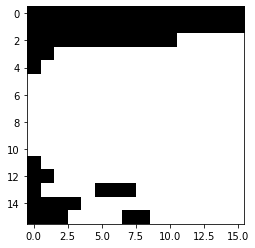

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

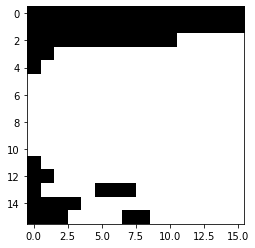



N:2 | p:0.4 | average pixel difference:4.0 | relative avg. p. diff:0.01 | number of pixels:512
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

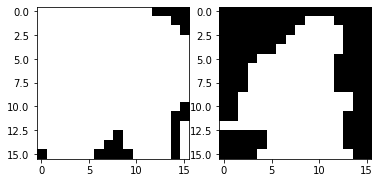

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

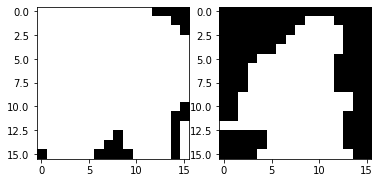



N:4 | p:0.4 | average pixel difference:85.0 | relative avg. p. diff:0.08 | number of pixels:1024
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

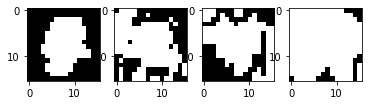

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

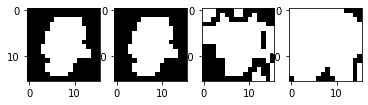



N:6 | p:0.4 | average pixel difference:247.0 | relative avg. p. diff:0.16 | number of pixels:1536
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

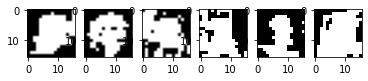

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

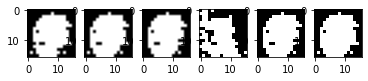



N:8 | p:0.4 | average pixel difference:441.0 | relative avg. p. diff:0.22 | number of pixels:2048
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

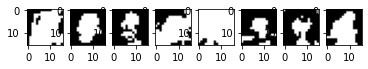

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

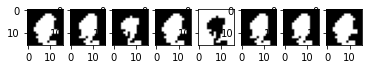



N:10 | p:0.4 | average pixel difference:606.0 | relative avg. p. diff:0.24 | number of pixels:2560
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

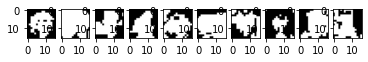

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

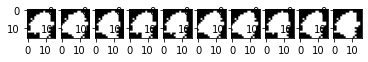

In [5]:
# Question 3
n_trials = 100
image_size = 16
p = 0.4

step_size = 2
N_list = np.array(range(0,10+step_size,step_size))
N_list[0]+=1
for N in N_list:
    pixel_diff = []
    for n in range(n_trials):
        images = load_random_simpsons_face(N,image_size)
        
        # binary images
        bins = convert_images2bin_pattern(images)
        # store in model
        model = ClassicalHopfield(bins.shape[1])
        model.store(bins)
        # corrupted images
        corr = corrupt_binary_patterns(bins, p_flip=p)
        # retrieve pattern
        retrieved = model.retrieve(corr)
        # calc pixel diff
        p_diff = np.sum(1/2*np.abs(bins - retrieved))
        pixel_diff.append(p_diff)
    
    print(f"N:{N} | p:{p} | average pixel difference:{np.around(np.mean(pixel_diff))} | relative avg. p. diff:{np.around(np.mean(pixel_diff)/(N*image_size**2), 2)} | number of pixels:{N*image_size**2}")
    print(f"Original Binary Patterns")
    show_images(bins)
    print(f"Retrieved Binary Patterns")
    show_images(retrieved)
    print("\n")
    

It can be seen that the retrieval works pretty good up to 5 patterns. From then on results get worse quickly.

## Exercise 5: Use the provided Dense Hopfield Network with exponential energy function and test is as before
The dense Hopfield Networks by [Demircigil et al. 2017](https://arxiv.org/abs/1702.01929) replace the quadratic form of the energy function with an exponential function. The energy function thus becomes:
$$\text{E}(\boldsymbol{\xi}) = -\sum_{i=1}^N \exp(\boldsymbol{x}_i^T\boldsymbol{\xi}).$$

Here $\boldsymbol{\xi}$ denotes the state pattern i.e. a corrupted pattern which is going to be restored with the modern Hopfield network and $\boldsymbol{x}_i$ denotes the stored pattern $i$ as a col-vector (Note that they are stored as row vectors in $\boldsymbol{X}$). 

The componentwise update rule for polar patterns $\boldsymbol{\xi} ∈ \{-1,+1\}^D$ is given by:
$$\boldsymbol{\xi}^\text{new}_k = \text{sgn}\left[-E\left(\boldsymbol{\xi}^{(+1,k)}\right) + E\left(\boldsymbol{\xi}^{(-1,k)}\right) \right].$$

Where $\boldsymbol{\xi}^\text{new}_k$ denotes the k-th component of the new state pattern and $\boldsymbol{\xi}^{(\pm1,k)}$ denotes the old state pattern $\boldsymbol{\xi}$ where the k-th component was set to $+1$ or $-1$ respectively.

The class `DenseHopfield` provides similar to the classical Hopfield example the three functions `store(X)`, `retrieve(X)` and `energy(X)` which are already implemented. Import the class from `models.py` and use the existing functions to answer the same three questions as for the classical Hopfield network. How do they compare?

*Question 1: What do you observe? Plot each step of your experiment. That is show the original images, the patterns, the corrupted and retrieved ones.*

*Question 2: Fixing the number of patterns to 5 and average over 100 trials, what is the maximum probability of flips the Hopfield network can handle? Give experimental evidence via some plots.*

*Question 3: Fixing the probability of flips to 0.4 and average over 100 trials, what is the maximum number of patterns the Hopfield network can restore? Give experimental evidence via some plots.*

In [6]:
from models import DenseHopfield
model = DenseHopfield(bins.shape[1])

################# original images #################


<Figure size 432x288 with 0 Axes>

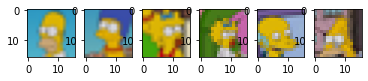

################# binary images ###################


<Figure size 432x288 with 0 Axes>

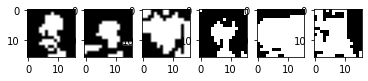

########## corrupted images: p=0.1 ###############


<Figure size 432x288 with 0 Axes>

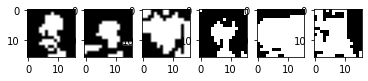

########## corrupted images: p=0.4 ###############


<Figure size 432x288 with 0 Axes>

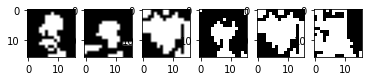

In [7]:
########## YOUR SOLUTION HERE ##########

# Question 1
print("################# original images #################")
images = load_random_simpsons_face(6,16)
show_images(images)

print("################# binary images ###################")
bins = convert_images2bin_pattern(images)
show_images(bins)

model.store(bins)

p = 0.1
print(f"########## corrupted images: p={p} ###############")
corr = corrupt_binary_patterns(bins, p_flip=p)
retrieved = model.retrieve(corr, max_iter=100)
show_images(retrieved)

p = 0.4
print(f"########## corrupted images: p={p} ###############")
corr = corrupt_binary_patterns(bins, p_flip=p)
retrieved = model.retrieve(corr, max_iter=100)
show_images(retrieved)

N:5 | p:0.0 | average pixel difference:0.0 | relative avg. p. diff:0.0 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

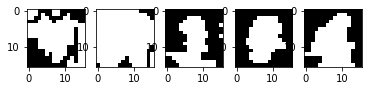

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

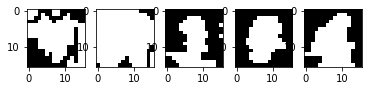



N:5 | p:0.1 | average pixel difference:0.0 | relative avg. p. diff:0.0 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

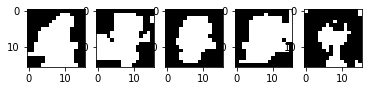

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

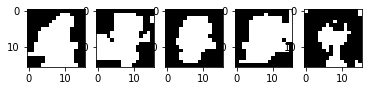



N:5 | p:0.2 | average pixel difference:0.0 | relative avg. p. diff:0.0 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

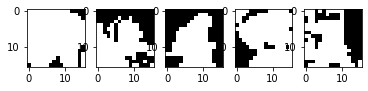

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

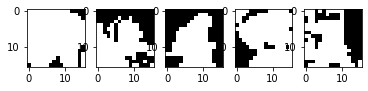



N:5 | p:0.3 | average pixel difference:0.0 | relative avg. p. diff:0.0 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

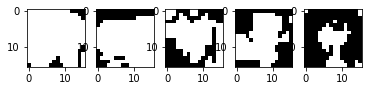

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

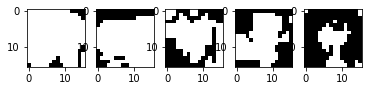



N:5 | p:0.4 | average pixel difference:35.0 | relative avg. p. diff:0.03 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

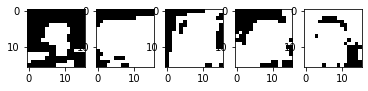

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

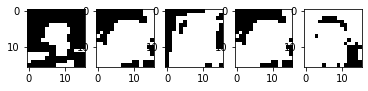



N:5 | p:0.5 | average pixel difference:383.0 | relative avg. p. diff:0.3 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

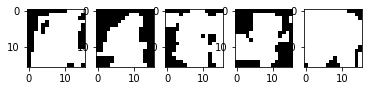

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

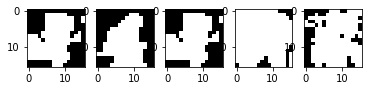



N:5 | p:0.6 | average pixel difference:575.0 | relative avg. p. diff:0.45 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

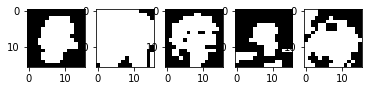

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

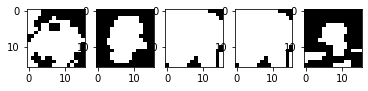

In [8]:
# Question 2
n_trials = 100
image_size = 16
N = 5

step_size = 10
p_list = np.array(range(0,60+step_size,step_size))/100
for p in p_list:
    pixel_diff = []
    model = DenseHopfield(bins.shape[1])
    for n in range(n_trials):
        images = load_random_simpsons_face(N,image_size)

        # binary images
        bins = convert_images2bin_pattern(images)
        # store in model
        model.store(bins)
        # corrupted images
        corr = corrupt_binary_patterns(bins, p_flip=p)
        # retrieve pattern
        retrieved = model.retrieve(corr, max_iter=100)
        # calc pixel diff
        p_diff = np.sum(1/2*np.abs(bins - retrieved))
        pixel_diff.append(p_diff)
    
    print(f"N:{N} | p:{p} | average pixel difference:{np.around(np.mean(pixel_diff))} | relative avg. p. diff:{np.around(np.mean(pixel_diff)/(N*image_size**2), 2)} | number of pixels:{N*image_size**2}")
    print(f"Original Binary Patterns")
    show_images(bins)
    print(f"Retrieved Binary Patterns")
    show_images(retrieved)
    print("\n")    
    
# Almost flawless up until p=0.4, does not start retrieving the negative image

N:1 | p:0.4 | average pixel difference:0.0 | relative avg. p. diff:0.0 | number of pixels:256
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

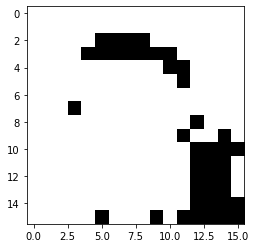

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

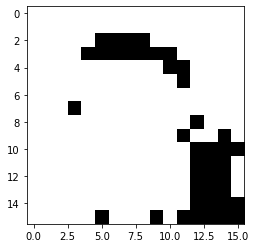



N:2 | p:0.4 | average pixel difference:3.0 | relative avg. p. diff:0.01 | number of pixels:512
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

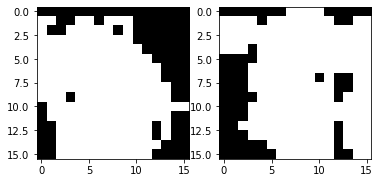

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

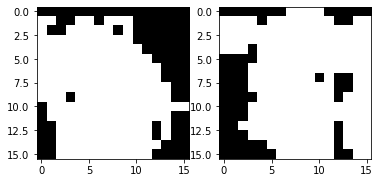



N:4 | p:0.4 | average pixel difference:26.0 | relative avg. p. diff:0.03 | number of pixels:1024
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

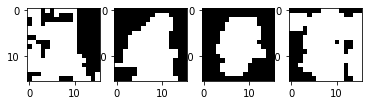

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

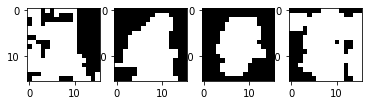



N:8 | p:0.4 | average pixel difference:83.0 | relative avg. p. diff:0.04 | number of pixels:2048
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

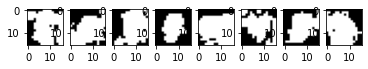

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

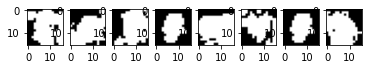



N:16 | p:0.4 | average pixel difference:256.0 | relative avg. p. diff:0.06 | number of pixels:4096
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

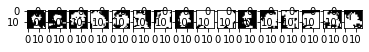

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

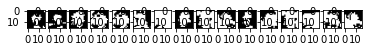

In [9]:
# Question 3
n_trials = 100
image_size = 16
p = 0.4

step_size = 1
N_list = 2 ** np.array(range(0,4+step_size,step_size))
for N in N_list:
    model = DenseHopfield(bins.shape[1])
    pixel_diff = []
    for n in range(n_trials):
        images = load_random_simpsons_face(N,image_size)
        
        # binary images
        bins = convert_images2bin_pattern(images)
        # store in model
        model.store(bins)
        # corrupted images
        corr = corrupt_binary_patterns(bins, p_flip=p)
        # retrieve pattern
        retrieved = model.retrieve(corr, max_iter=100)
        # calc pixel diff
        p_diff = np.sum(1/2*np.abs(bins - retrieved))
        pixel_diff.append(p_diff)
    
    print(f"N:{N} | p:{p} | average pixel difference:{np.around(np.mean(pixel_diff))} | relative avg. p. diff:{np.around(np.mean(pixel_diff)/(N*image_size**2), 2)} | number of pixels:{N*image_size**2}")
    print(f"Original Binary Patterns")
    show_images(bins)
    print(f"Retrieved Binary Patterns")
    show_images(retrieved)
    print("\n")

# very robust for storing large N of patterns -> realitve pixel error does not really increase

## Exercise 6: 
1. Argue why the proposed update rule minimizes the exponential energy function.
2. Incorporate the lse function into the energy function of the dense Hopfield network using the definition of the lse function below:
$$\text{lse}(\beta, \boldsymbol{z}) = \beta^{-1} \log \left( \sum_{l=1}^N \text{exp}(\beta z_l) \right).$$

########## YOUR SOLUTION HERE ##########

## Exercise 7: Test the Modern Hopfield Network with the lse energy function
The modern Hopfield Network by Ramsauer et al. 2020 extends the energy function of Dense Hopfield networks to be able to work with continuous-valued patterns. The energy function is now:
$$\text{E} = -\text{lse}\big(\beta,\boldsymbol{X}^T\boldsymbol{\xi}\big) + \frac{1}{2} \boldsymbol{\xi}^T\boldsymbol{\xi} + \beta^{-1}\log N + \frac{1}{2} M^2$$

Here M denotes the largest norm of all stored patterns. The new update rule for patterns $\boldsymbol{\xi} \in \mathbb{R}^D$ is given by:
$$\boldsymbol{\xi}^{\text{new}} = \boldsymbol{X}\text{softmax}\big(\beta \boldsymbol{X}^T \boldsymbol{\xi} \big).$$


1. Since the patterns are now in a continuous domain we need to write new converter functions. Write the function `convert_images2cont_pattern(images)` which converts the image to gray scale that is the image has only one channel and it's pixels lie in the interval $[-1,+1]$. The red channel is weighted with 0.21, the green channel with 0.72 and the blue channel with 0.07.

2. The distortion function needs to be adapted as well. Write the function `corrupt_cont_patterns(patterns, p_flip)` which sets each pixel with the probability `p_flip` to the value 0.

3. Test your functions and visualize the results. i.e. show the original image, the gray-scale image and the corrupted image for a) 0.1 and b) 0.4 using `corrupt_cont_patterns` and try to restore the original patterns using `retrieve(self,X)` of the Modern Hopfield network (see task 4). For continous patterns use the cmap `gray` in the function `plt.imshow()`. 

4. The class `ModernHopfield` provides similar to the classical Hopfield example the three functions `store(X)`, `retrieve(X)` and `energy(X)` which are already implemented. Import the class from `models.py` and use the existing functions to answer the same three questions as for the classical Hopfield network. Note that we can provide a $\beta$ parameter during instantiation of the ModernHopfield network. Use $\beta=32$ and use `max_iter=100` in the retrieve-function. How do they compare? 

*Question 1: What do you observe? Plot each step of your experiment. That is show the original images, the patterns, the corrupted and retrieved ones.*

*Question 2: Fixing the number of patterns to 5 and average over 100 trials, what is the maximum probability of flips the Hopfield network can handle? Give experimental evidence via some plots.*

*Question 3: Fixing the probability of flips to 0.4 and average over 100 trials, what is the maximum number of patterns the Hopfield network can restore? Give experimental evidence via some plots.*

5. Do you recognize the update rule? Explain how it relates to Key-Value attention?

In [10]:
from models import ModernHopfield

def convert_images2cont_pattern(images):
    """converts images to continuous black and white with pixel values
    in interval [-1,+1]

    Args:
        images (np.ndarray): batch of images as np.array of shape N x D x D x C

    Returns:
        np.ndarray: numpy array with shape N x D*D
    """
    N, D,_,C = images.shape
    assert C == 3, 'invalid image shape'
    ########## YOUR SOLUTION HERE ##########
    imgs_pil = [Image.fromarray(image, "RGB") for image in images]
    imgs_gray = np.array([np.asarray(img.convert("L")) for img in imgs_pil])
    imgs_gray = np.array([np.interp(img, (img.min(), img.max()), (-1, +1)) for img in imgs_gray])
    return imgs_gray.reshape(imgs_gray.shape[0],-1)

def corrupt_cont_patterns(patterns, p_flip=.1):
    """corrupts continuous pattern by setting each pixel with probability p_flip to 0.
    A pixel has values in the interval [-1, +1].
    
    Args:
        patterns (np.ndarray): batch of patterns as np.array of shape N x D**2
        
    Returns:
        np.ndarray: corrupted numpy array with same shape as patterns
    """
    N, D2 = patterns.shape
    ########## YOUR SOLUTION HERE ##########
    flip_matrix = rng.choice([1,0], size=patterns.shape, p=[1-p_flip, p_flip])
    return patterns*flip_matrix


############ Original ############


<Figure size 432x288 with 0 Axes>

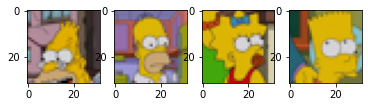

############ Grayscale ############


<Figure size 432x288 with 0 Axes>

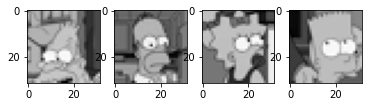



############ Corrupted with p=0.1 ############


<Figure size 432x288 with 0 Axes>

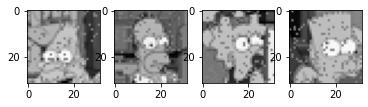

############ Retrieved with p=0.1 ############


<Figure size 432x288 with 0 Axes>

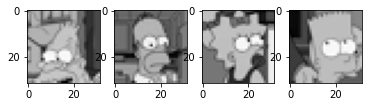



############ Corrupted with p=0.4 ############


<Figure size 432x288 with 0 Axes>

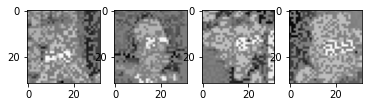

############ Retrieved with p=0.4 ############


<Figure size 432x288 with 0 Axes>

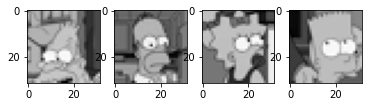

In [11]:
# Question 1
images = load_random_simpsons_face(4,32)
print("############ Original ############")
show_images(images)

gray = convert_images2cont_pattern(images)
print("############ Grayscale ############")
show_images(gray, cmap="gray")
print("\n")

model = ModernHopfield(gray.shape[1], beta=32)
model.store(gray)

for p in [0.1,0.4]:
    corr = corrupt_cont_patterns(gray, p_flip=p)
    print(f"############ Corrupted with p={p} ############")
    show_images(corr, cmap="gray")
    
    retrieved = model.retrieve(corr, max_iter=100)
    print(f"############ Retrieved with p={p} ############")
    show_images(retrieved, cmap="gray")
    print("\n")

N:5 | p:0.0 | average pixel difference:0.0 | relative avg. p. diff:0.0 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

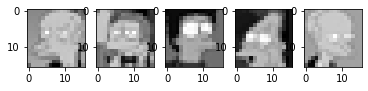

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

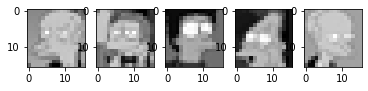



N:5 | p:0.1 | average pixel difference:0.0 | relative avg. p. diff:0.0 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

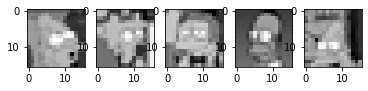

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

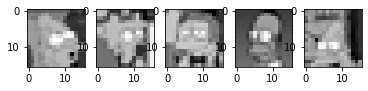



N:5 | p:0.2 | average pixel difference:0.0 | relative avg. p. diff:0.0 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

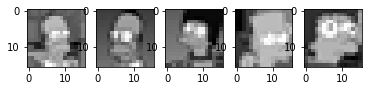

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

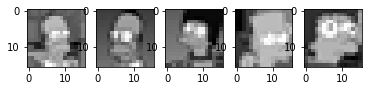



N:5 | p:0.3 | average pixel difference:0.0 | relative avg. p. diff:0.0 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

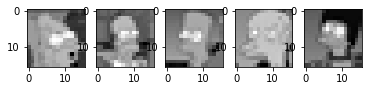

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

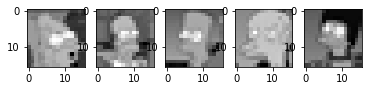



N:5 | p:0.4 | average pixel difference:0.0 | relative avg. p. diff:0.0 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

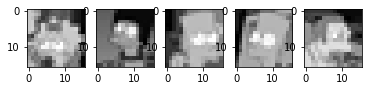

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

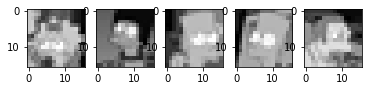



N:5 | p:0.5 | average pixel difference:1.0 | relative avg. p. diff:0.0 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

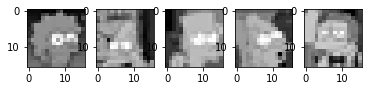

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

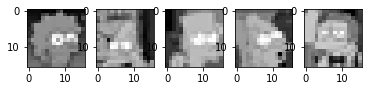



N:5 | p:0.6 | average pixel difference:3.0 | relative avg. p. diff:0.0 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

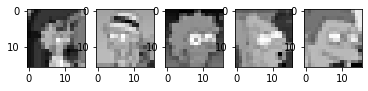

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

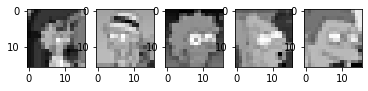



N:5 | p:0.7 | average pixel difference:1.0 | relative avg. p. diff:0.0 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

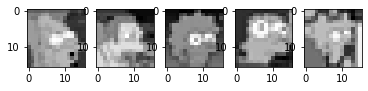

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

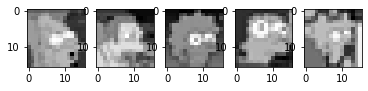



N:5 | p:0.8 | average pixel difference:6.0 | relative avg. p. diff:0.0 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

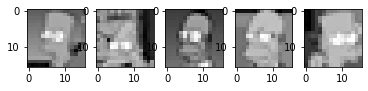

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

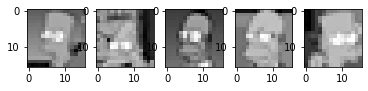



N:5 | p:0.9 | average pixel difference:9.0 | relative avg. p. diff:0.01 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

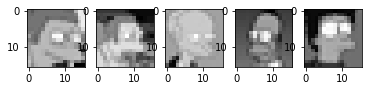

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

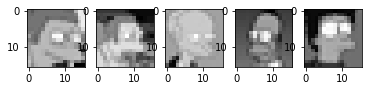



N:5 | p:1.0 | average pixel difference:226.0 | relative avg. p. diff:0.18 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

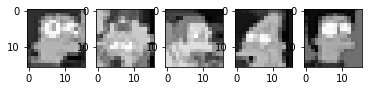

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

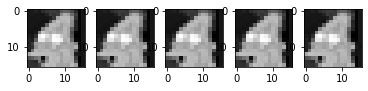

In [12]:
# Question 2
n_trials = 100
image_size = 16
N = 5

step_size = 10
p_list = np.array(range(0,100+step_size,step_size))/100
for p in p_list:
    pixel_diff = []
    model = ModernHopfield(image_size**2, beta=32)
    for n in range(n_trials):
        images = load_random_simpsons_face(N,image_size)

        # gray images
        gray = convert_images2cont_pattern(images)
        # store in model
        model.store(gray)
        # corrupted images
        corr = corrupt_cont_patterns(gray, p_flip=p)
        # retrieve pattern
        retrieved = model.retrieve(corr, max_iter=100)
        # calc pixel diff
        p_diff = np.sum(1/2*np.abs(gray - retrieved))
        pixel_diff.append(p_diff)
    
    print(f"N:{N} | p:{p} | average pixel difference:{np.around(np.mean(pixel_diff))} | relative avg. p. diff:{np.around(np.mean(pixel_diff)/(N*image_size**2), 2)} | number of pixels:{N*image_size**2}")
    print(f"Original Binary Patterns")
    show_images(gray, "gray")
    print(f"Retrieved Binary Patterns")
    show_images(retrieved, "gray")
    print("\n")    
    
# Works extremely well even for high p

N:1 | p:0.4 | average pixel difference:0.0 | relative avg. p. diff:0.0 | number of pixels:256
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

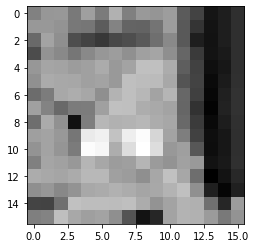

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

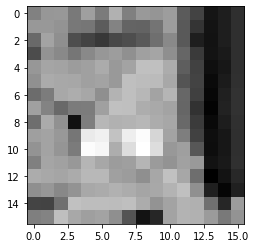



N:2 | p:0.4 | average pixel difference:0.0 | relative avg. p. diff:0.0 | number of pixels:512
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

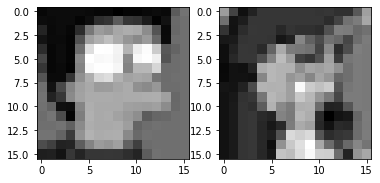

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

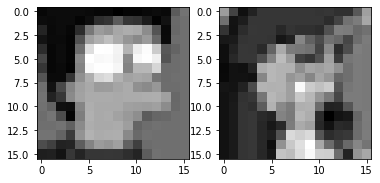



N:4 | p:0.4 | average pixel difference:1.0 | relative avg. p. diff:0.0 | number of pixels:1024
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

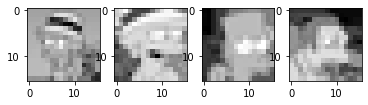

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

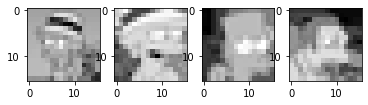



N:8 | p:0.4 | average pixel difference:1.0 | relative avg. p. diff:0.0 | number of pixels:2048
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

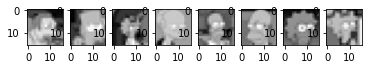

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

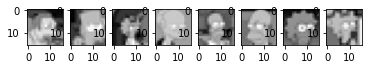



N:16 | p:0.4 | average pixel difference:7.0 | relative avg. p. diff:0.0 | number of pixels:4096
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

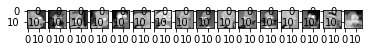

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

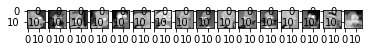

In [13]:
# Question 3
n_trials = 100
image_size = 16
p = 0.4

step_size = 1
N_list = 2 ** np.array(range(0,4+step_size,step_size))
for N in N_list:
    pixel_diff = []
    model = ModernHopfield(image_size**2, beta=32)
    for n in range(n_trials):
        images = load_random_simpsons_face(N,image_size)

        # gray images
        gray = convert_images2cont_pattern(images)
        # store in model
        model.store(gray)
        # corrupted images
        corr = corrupt_cont_patterns(gray, p_flip=p)
        # retrieve pattern
        retrieved = model.retrieve(corr, max_iter=100)
        # calc pixel diff
        p_diff = np.sum(1/2*np.abs(gray - retrieved))
        pixel_diff.append(p_diff)
    
    print(f"N:{N} | p:{p} | average pixel difference:{np.around(np.mean(pixel_diff))} | relative avg. p. diff:{np.around(np.mean(pixel_diff)/(N*image_size**2), 2)} | number of pixels:{N*image_size**2}")
    print(f"Original Binary Patterns")
    show_images(gray, "gray")
    print(f"Retrieved Binary Patterns")
    show_images(retrieved, "gray")
    print("\n")    
    
# Works extremely well even for high N


5. Do you recognize the update rule? Explain how it relates to Key-Value attention?

$$\boldsymbol{\xi}^{\text{new}} = \boldsymbol{X}\text{softmax}\big(\beta \boldsymbol{X}^T \boldsymbol{\xi} \big).$$


This update rule can be seen as Key-Value attention:
* The softmax term can be seen as the attention vector -> softmax applied to attention score. <br> The attention score in this setting is how similary the current pattern xi is to the stored patterns X which is calculted by the taking the dot product inside the softmax. Applying the softmax maps the similarity score to a probabilistic scale, which gives us the attention vector.
* The output xi_new is then calculated as the weighted combination of attention vector and the stored patterns. 

So the update rule can be seen as key-value attention with keys and values being equal to the stored patterns X and the current input xi is equal to the query key.

## Bonus Excercise 8: Modern Hopfield behaviour for different betas

Investigate and visualize how the modern Hopfield storage capacity and error resilience behaves with different $\beta$.


Beta:0.0001 | N:5 | p:0.5 | average pixel difference:181.0 | relative avg. p. diff:0.14 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

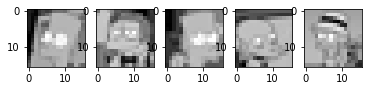

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

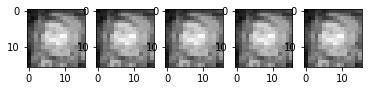



Beta:0.001 | N:5 | p:0.5 | average pixel difference:179.0 | relative avg. p. diff:0.14 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

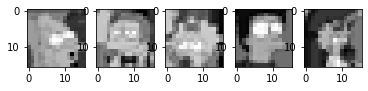

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

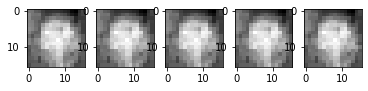



Beta:0.01 | N:5 | p:0.5 | average pixel difference:184.0 | relative avg. p. diff:0.14 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

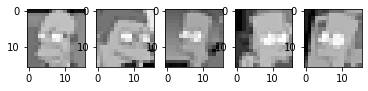

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

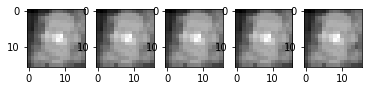



Beta:0.1 | N:5 | p:0.5 | average pixel difference:152.0 | relative avg. p. diff:0.12 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

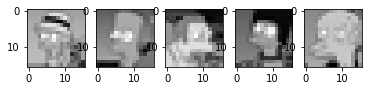

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

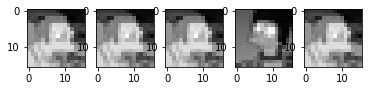



Beta:1.0 | N:5 | p:0.5 | average pixel difference:7.0 | relative avg. p. diff:0.01 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

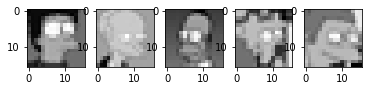

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

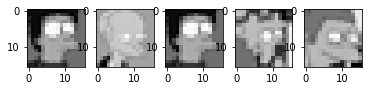



Beta:10.0 | N:5 | p:0.5 | average pixel difference:4.0 | relative avg. p. diff:0.0 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

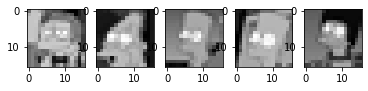

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

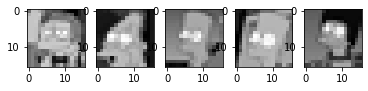



Beta:100.0 | N:5 | p:0.5 | average pixel difference:0.0 | relative avg. p. diff:0.0 | number of pixels:1280
Original Binary Patterns


<Figure size 432x288 with 0 Axes>

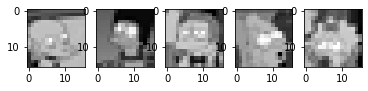

Retrieved Binary Patterns


<Figure size 432x288 with 0 Axes>

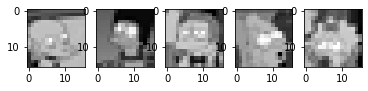

In [14]:
########## YOUR SOLUTION HERE ##########

# Question 2
n_trials = 100
image_size = 16
N = 5
p = 0.5

step_size = 1
beta_list = np.logspace(-4,2, 7)
for beta in beta_list:
    pixel_diff = []
    model = ModernHopfield(image_size**2, beta=beta)
    for n in range(n_trials):
        images = load_random_simpsons_face(N,image_size)

        # gray images
        gray = convert_images2cont_pattern(images)
        # store in model
        model.store(gray)
        # corrupted images
        corr = corrupt_cont_patterns(gray, p_flip=p)
        # retrieve pattern
        retrieved = model.retrieve(corr, max_iter=100)
        # calc pixel diff
        p_diff = np.sum(1/2*np.abs(gray - retrieved))
        pixel_diff.append(p_diff)
    
    print(f"Beta:{beta} | N:{N} | p:{p} | average pixel difference:{np.around(np.mean(pixel_diff))} | relative avg. p. diff:{np.around(np.mean(pixel_diff)/(N*image_size**2), 2)} | number of pixels:{N*image_size**2}")
    print(f"Original Binary Patterns")
    show_images(gray, "gray")
    print(f"Retrieved Binary Patterns")
    show_images(retrieved, "gray")
    print("\n")    
    
# Works extremely well even for high p


Low beta allows for so called "meta stable states" as they call them in the paper. For low beta the retrieved patterns are a mixture of all stored patterns and they are not clearly separated. By increasing beta this changes and the patterns start to get separated more clearly.
* small beta -> more uniform attention vector
* large beta -> attention vector gets one-hot